>학번 : 2017250024

>이름 : 오재영


## 기본 설정

In [235]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 과제 1
조기 종료를 사용한 배치 경사 하강법으로 로지스틱 회귀를 구현하라. 단, 사이킷런을 전혀 사용하지 않아야 한다.

## 데이터 준비

붓꽃 데이터셋을 불러오기 위해서 사이킷런에서 제공하는 붓꽃 데이터셋을 불러왔다.

* (오직 데이터셋을 불러오기 위해서 사용한다. 로지스틱 회귀를 구현하는 과정에서는 사용하지 않을 것이다.) 

In [236]:
from sklearn import datasets
iris = datasets.load_iris()

꽃잎 길이(petal length)와 꽃잎 너비(petal width) 특성을 이용하여 버지니카 품종 여부를 판정하는 데에 사용되는 데이터셋을 지정한다.

In [237]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이(petal length), 꽃잎 넓이(petal width) 특성 사용
y = (iris["target"] == 2).astype(np.int)  # 0이면 음성 (버지니카(Virginica) 품종이 아닐 때 ), 1이면 양성 (버지니카(Virginica) 품종일 때)

모든 샘플에 편향을 추가한다. 이유는 아래 수식을 행렬 연산으로 보다 간단하게
처리하기 위해 0번 특성값 $x_0$이 항상 1이라고 가정하기 때문이다. 

$$
\theta_0\cdot 1 + \theta_1\cdot x_1 + \cdots + \theta_n\cdot x_n =
\theta_0\cdot x_0 + \theta_1\cdot x_1 + \cdots + \theta_n\cdot x_n
$$

In [238]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

일정한 결과를 유지하기 위해 랜덤 시드를 지정한다.

In [239]:
np.random.seed(2042) #숫자는 상관 없음.

## 데이터셋 분할

데이터셋을 훈련, 검증, 테스트 용도로 6대 2대 2의 비율로 무작위로 분할한다.

In [240]:
test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
total_size = len(X_with_bias)                            # 전체 데이터셋 크기

test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
train_size = total_size - test_size - validation_size    # 훈련 세트 크기: 전체의 60%

`np.random.permutation()` 함수를 이용하여 인덱스를 무작위로 섞는다.

In [241]:
rnd_indices = np.random.permutation(total_size)

인덱스가 무작위로 섞였기 때문에 무작위로 분할하는 효과를 얻는다. 

* 섞인 인덱스를 이용하여 지정된 6:2:2의 비율로 훈련, 검증, 테스트 세트로 분할하는 방법 사용

In [242]:
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

## 로지스틱 회귀 구현

* 로지스틱 회귀 : 파라미터와 특성값들의 선형합에 시그모이드 함수를 적용하여 양성 확률을 추정하는 이진 분류 모델

### 시그모이드 함수 정의

* 시그모이드 함수 : 어떤 숫자가 들어와도 0과 1 사이의 값으로 변환해주는 함수.

* (로지스틱 회귀를 구현하는데 있어서 필수적이다.)
$$
\sigma(t) = \frac{1}{1 + e^{-t}}
$$
> (e(e=2.718281...)는 자연 상수)

In [243]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

<function matplotlib.pyplot.show>

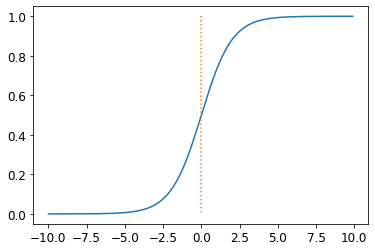

In [244]:
# 간략한 시그모이드 함수를 보여주는 그래프
ara = np.arange(-10, 10, 0.1)
sig = sigmoid(ara)
plt.plot(ara, sig)
plt.plot([0,0],[1.0,0.0], ':') # 가운데 점선을 추가해주는 코드
plt.show

파라미터 $\Theta$를 무작위로 초기 설정한다.

In [245]:
n_inputs = X_train.shape[1] # 특성 수(n) + 1, 붓꽃의 경우: 특성 2개 + 1

In [246]:
Theta = np.random.randn(n_inputs) # 세타값을 무작위로 초기화한다.

## 경사하강법 활용 훈련

### 경사 하강법 훈련 함수

* `learning_rate` : 학습률
* `epsilon` : $\log$ 값이 항상 계산되도록 더해지는 작은 실수
* `n_iterations` : 에포크 수
* `m` : 훈련 세트 크기, 즉 훈련 샘플 수
* `logits` : 모든 샘플에 대한 클래스별 점수, 즉 $\mathbf{X}_{\textit{train}}\, \Theta$
* `Y_proba` : 모든 샘플에 대해 계산된 클래스 별 소속 확률, 즉 $\hat P$

In [247]:
learning_rate = 0.1   # 학습률
epsilon = 1e-7         # log 값이 항상 계산되도록 더해지는 작은 실수
n_iterations = 5001    # 에포크 수
m = len(X_train)       # 훈련 세트 크기


for iteration in range(n_iterations):     # 5001번 반복 훈련
    logits = X_train.dot(Theta)
    Y_proba = sigmoid(logits)
   
    if iteration % 500 == 0:              # 500 에포크마다 손실(비용) 계산해서 출력
      loss = -np.mean(np.sum((y_train*np.log(Y_proba + epsilon) + (1-y_train)*np.log(1 - Y_proba + epsilon))))  # 손실 함수
      print(iteration, loss)
    
    error = Y_proba - y_train             # 그레이디언트 계산.
    gradients = 1/m * X_train.T.dot(error)
    
    Theta = Theta - learning_rate * gradients       # 파라미터 업데이트

0 64.36764197429221
500 49.0675996532536
1000 44.396192284525625
1500 42.479741738754846
2000 41.54714898005549
2500 41.04432545213079
3000 40.754634920308774
3500 40.57996306011109
4000 40.47114598460859
4500 40.4016935601258
5000 40.35654247199624


학습된 파라미터는 다음과 같다.

In [248]:
Theta

array([-2.44437711,  7.36763324])

### 정확도 측정

검증세트를 이용하여 모델 성능을 측정한다.

Y_proba값이 0.5 이상이면 1로 판단 양성(즉, 버지니아이다.) 0.5 이하면 0으로 판단 음성(즉, 버지니아가 아니다.)

In [249]:
logits = X_valid.dot(Theta)              
Y_proba = sigmoid(logits)
y_predict = np.array([])
for i in range(len(Y_proba)):
  if Y_proba[i] >= 0.5:
    y_predict = np.append(y_predict, 1)
  else:
    y_predict = np.append(y_predict, 0)

accuracy_score = np.mean(y_predict == y_valid)  # 정확도 계산
accuracy_score

0.8666666666666667

정확도가 대략 86%가 나왔다.

* 예측값

In [250]:
y_predict

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])

* 실제값

In [251]:
y_valid

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1])

### 규제 추가

위의 알고리즘에 l2규제(릿지 규제)를 추가할 것이다.

* `learning_rate` : 학습률
* `epsilon` : $\log$ 값이 항상 계산되도록 더해지는 작은 실수
* `n_iterations` : 에포크 수
* `m` : 훈련 세트 크기, 즉 훈련 샘플 수
* `logits` : 모든 샘플에 대한 클래스별 점수, 즉 $\mathbf{X}_{\textit{train}}\, \Theta$
* `Y_proba` : 모든 샘플에 대해 계산된 클래스 별 소속 확률, 즉 $\hat P$
* `alpha` : 규제 하이퍼파라미터

In [252]:
learning_rate = 0.1    # 학습률
epsilon = 1e-7         # log 값이 항상 계산되도록 더해지는 작은 실수
n_iterations = 5001    # 에포크 수
m = len(X_train)       # 훈련 세트 크기
alpha = 0.1            # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs)  # 세타값을 초기화한다.

for iteration in range(n_iterations):     # 5001번 반복 훈련
    logits = X_train.dot(Theta)
    Y_proba = sigmoid(logits)
   
    if iteration % 500 == 0:              # 500 에포크마다 손실(비용) 계산해서 출력
      xentropy_loss = -np.mean(np.sum((y_train*np.log(Y_proba + epsilon) + (1-y_train)*np.log(1 - Y_proba + epsilon)))) # 손실 함수
      l2_loss = 1/2 * np.sum(np.square(Theta[1:]))  # 편향은 규제에서 제외
      loss = xentropy_loss + alpha * l2_loss        # l2 규제가 추가된 손실
      print(iteration, loss)
    
    error = Y_proba - y_train             # 그레이디언트 계산.
    l2_loss_gradients = np.r_[np.zeros([1]), alpha * Theta[1:]]   # l2 규제 그레이디언트
    gradients = 1/m * X_train.T.dot(error) + l2_loss_gradients
    
    Theta = Theta - learning_rate * gradients       # 파라미터 업데이트

0 60.10374540345941
500 57.90423273764737
1000 57.89657837548702
1500 57.89653596088129
2000 57.89653572581438
2500 57.89653572451161
3000 57.89653572450439
3500 57.89653572450438
4000 57.89653572450438
4500 57.89653572450438
5000 57.89653572450438


검증세트로 정확도를 측정한다.

In [253]:
logits = X_valid.dot(Theta)              
Y_proba = sigmoid(logits)
y_predict = np.array([])
for i in range(len(Y_proba)):
  if Y_proba[i] >= 0.5:
    y_predict = np.append(y_predict, 1)
  else:
    y_predict = np.append(y_predict, 0)

accuracy_score = np.mean(y_predict == y_valid)  # 정확도 계산
accuracy_score

0.8666666666666667

검증세트로 테스트 했을 때는 정확도가 규제 적용 전과 같게 나왔다.

### 조기종료 기능 추가

조기종료란 검증세트에 대한 손실값이 이전 단계보다 커지면
바로 종료되는 것을 말한다.

조기종료 기능을 추가 후, 조기종료가 잘 되는지 테스트 해본다.

In [254]:
learning_rate = 0.1    # 학습률
epsilon = 1e-7         # log 값이 항상 계산되도록 더해지는 작은 실수
n_iterations = 5001    # 에포크 수
m = len(X_train)       # 훈련 세트 크기
alpha = 0.1            # 규제 하이퍼파라미터
best_loss = np.infty   # 최소 손실값 기억 변수

Theta = np.random.randn(n_inputs)  # 세타값을 초기화한다.

for iteration in range(n_iterations):

    # 훈련 및 손실 계산
    logits = X_train.dot(Theta)
    Y_proba = sigmoid(logits)
    error = Y_proba - y_train
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1]), alpha * Theta[1:]]
    Theta = Theta - learning_rate * gradients
    
    # 검증 세트에 대한 손실 계산
    logits = X_valid.dot(Theta)
    Y_proba = sigmoid(logits)
    xentropy_loss = -np.mean(np.sum((y_valid*np.log(Y_proba + epsilon) + (1-y_valid)*np.log(1 - Y_proba + epsilon))))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
   
    if iteration % 1000 == 0:              # 1000 에포크마다 손실(비용) 계산해서 출력
      print(iteration, loss)

    # 에포크마다 최소 손실값 업데이트
    if loss < best_loss:
        best_loss = loss
    else:                                      # 에포크가 줄어들지 않으면 바로 훈련 종료
        print(iteration - 1, best_loss)        # 종료되기 이전 에포크의 손실값 출력
        print(iteration, loss, "조기 종료")
        break

0 43.720160123235566
1000 18.998986521221155
2000 18.998903714755507
2779 18.998903712212798
2780 18.998903712212798 조기 종료!


조기종료 기능이 잘 구현된 것을 확인할 수 있다.

## 정확도 측정 (최종)

이제 최종적으로 테스트 세트를 사용하여 모델의 정확도를 측정한다.

In [255]:
logits = X_test.dot(Theta)
Y_proba = sigmoid(logits)
y_predict = np.array([])
for i in range(len(Y_proba)):
  if Y_proba[i] >= 0.5:
    y_predict = np.append(y_predict, 1)
  else:
    y_predict = np.append(y_predict, 0)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.8666666666666667

최종적으로 약 86.6%로 나왔다. 성능은 그닥 좋지 않지만 사이킷런을 사용하지 않고 구현에 성공했다.

# 과제 2
과제 1에서 구현된 로지스틱 회귀 알고리즘에 일대다(OvR) 방식을 적용하여 붓꽃에 대한 다중 클래스 분류 알고리즘을 구현하라. 단, 사이킷런을 전혀 사용하지 않아야 한다.


## 데이터 준비

2개의 모델을 사용한다.
꽃잎 길이와 꽃잎 넓이 특성을 이용하여 세토사, 버지니카 품종 여부를 판정하는 데에 사용되는 데이터셋을 지정한다.
* 세토사 품종 여부를 판정하는 데이터셋 지정
* 버지니카 품종 여부를 판정하는 데이터셋 지정

In [264]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]
y0 = (iris["target"] == 0).astype(np.int) # 세토사 
y1 = (iris["target"] == 2).astype(np.int) # 버지니카

편향을 추가한다.

In [265]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

일정한 결과를 유지하기 위해 랜덤 시드를 지정한다.

In [266]:
np.random.seed(2042)

## 데이터셋 분할

데이터셋을 훈련, 검증, 테스트 용도로 6대 2대 2의 비율로 무작위로 분할한다.

In [267]:
test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
total_size = len(X_with_bias)                            # 전체 데이터셋 크기

test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
train_size = total_size - test_size - validation_size    # 훈련 세트 크기: 전체의 60%

`np.random.permutation()` 함수를 이용하여 인덱스를 무작위로 섞는다.

In [268]:
rnd_indices = np.random.permutation(total_size)

인덱스가 무작위로 섞였기 때문에 무작위로 분할하는 효과를 얻는다. 

* 섞인 인덱스를 이용하여 지정된 6:2:2의 비율로 훈련, 검증, 테스트 세트로 분할하는 방법 사용

2개의 모델을 이용할 것이기 때문에 세토사(setosa)에 대한 데이터셋, 버지니카(virginica)에 대한 데이터셋을 따로 개별적으로 준비한다.

In [269]:
X_train = X_with_bias[rnd_indices[:train_size]] 
y_train = y[rnd_indices[:train_size]]
y_set_train = y0[rnd_indices[:train_size]] # setosa
y_vir_train = y1[rnd_indices[:train_size]] # virginica

X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
y_set_valid = y0[rnd_indices[train_size:-test_size]] # setosa
y_vir_valid = y1[rnd_indices[train_size:-test_size]] # virginica

X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [270]:
n_inputs = X_train.shape[1]
Theta0 = np.random.randn(n_inputs) # setosa 인지 여부를 판단하기 위한 모델의 세타값
Theta1 = np.random.randn(n_inputs) # virginica 인지 여부를 판단하기 위한 모델의 세타값

## 로지스틱 회귀 구현

* 세토사(setosa)인지 여부를 판단하기 위한 모델

In [273]:
learning_rate = 0.1        # 학습률
epsilon = 1e-7             # log 값이 항상 계산되도록 더해지는 작은 실수
n_iterations = 5001        # 에포크 수
m = len(X_train)           # 훈련 세트 크기
alpha = 0.1                # 규제 하이퍼파라미터
set_best_loss = np.infty   # 최소 손실값 기억 변수

set_Theta = np.random.randn(n_inputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    # 훈련 및 손실 계산
    set_logits = X_train.dot(set_Theta)
    Y_set_proba = sigmoid(set_logits)
    error = Y_set_proba - y_set_train
    set_gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1]), alpha * set_Theta[1:]]
    set_Theta = set_Theta - learning_rate * set_gradients

    # 검증 세트에 대한 손실 계산
    set_logits = X_valid.dot(set_Theta)
    Y_set_proba = sigmoid(set_logits)
    set_xentropy_loss = -np.mean(np.sum((y_set_valid*np.log(Y_set_proba + epsilon) + (1-y_set_valid)*np.log(1 - Y_set_proba + epsilon))))
    set_l2_loss = 1/2 * np.sum(np.square(set_Theta[1:]))
    set_loss = set_xentropy_loss + alpha * set_l2_loss
    
    # 500 에포크마다 검증 세트에 대한 손실 출력
    if iteration % 500 == 0:
        print(iteration, set_loss)
        
    # 에포크마다 최소 손실값 업데이트
    if set_loss < set_best_loss:
        set_best_loss = set_loss
    else:                                          # 에포크가 줄어들지 않으면 바로 훈련 종료
        print(iteration - 1, set_best_loss)        # 종료되기 이전 에포크의 손실값 출력
        print(iteration, set_loss, "조기 종료")
        break

0 26.905616258645264
500 4.003743762121255
1000 3.737107717302366
1500 3.6671964254307907
2000 3.645061183844694
2500 3.6375672193741426
3000 3.6349690891215927
3500 3.6340607447815563
4000 3.6337422366188807
4500 3.6336304369363406
5000 3.6335911797987333


* 버지니카(virginica)인지 여부를 판단하기 위한 모델

In [274]:
learning_rate = 0.1        # 학습률
epsilon = 1e-7             # log 값이 항상 계산되도록 더해지는 작은 실수
n_iterations = 5001        # 에포크 수
m = len(X_train)           # 훈련 세트 크기
alpha = 0.1                # 규제 하이퍼파라미터
vir_best_loss = np.infty   # 최소 손실값 기억 변수

vir_Theta = np.random.randn(n_inputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    # 훈련 및 손실 계산
    vir_logits = X_train.dot(vir_Theta)
    Y_vir_proba = sigmoid(vir_logits)
    error = Y_vir_proba - y_vir_train
    vir_gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1]), alpha * vir_Theta[1:]]
    vir_Theta = vir_Theta - learning_rate * vir_gradients

    # 검증 세트에 대한 손실 계산
    vir_logits = X_valid.dot(vir_Theta)
    Y_vir_proba = sigmoid(vir_logits)
    vir_xentropy_loss = -np.mean(np.sum((y_vir_valid*np.log(Y_vir_proba + epsilon) + (1-y_vir_valid)*np.log(1 - Y_vir_proba + epsilon))))
    vir_l2_loss = 1/2 * np.sum(np.square(vir_Theta[1:]))
    vir_loss = vir_xentropy_loss + alpha * vir_l2_loss
    
    # 500 에포크마다 검증 세트에 대한 손실 출력
    if iteration % 500 == 0:
        print(iteration, vir_loss)
        
    # 에포크마다 최소 손실값 업데이트
    if vir_loss < vir_best_loss:
        vir_best_loss = vir_loss
    else:                                          # 에포크가 줄어들지 않으면 바로 훈련 종료
        print(iteration - 1, vir_best_loss)        # 종료되기 이전 에포크의 손실값 출력
        print(iteration, vir_loss, "조기 종료")
        break

0 95.01306225869985
500 10.782754134134866
1000 9.497810192747188
1500 8.982839338165343
2000 8.715105856499614
2500 8.559273376170394
3000 8.463025735440624
3500 8.401489203954531
4000 8.361297373101415
4500 8.33468652860064
5000 8.316910243929565


### 정확도 측정

검증세트를 사용하여 정확도를 측정한다.

In [276]:
set_logits = X_valid.dot(set_Theta)              
Y_set_proba = sigmoid(set_logits)
y_set_predict = np.array([])
for i in range(len(Y_set_proba)):
  if Y_set_proba[i] >= 0.5:
    y_set_predict = np.append(y_set_predict, 1)
  else:
    y_set_predict = np.append(y_set_predict, 0)

accuracy_score = np.mean(y_set_predict == y_set_valid)  # 정확도 계산
accuracy_score

1.0

In [277]:
vir_logits = X_valid.dot(vir_Theta)              
Y_vir_proba = sigmoid(vir_logits)
y_vir_predict = np.array([])
for i in range(len(Y_vir_proba)):
  if Y_vir_proba[i] >= 0.5:
    y_vir_predict = np.append(y_vir_predict, 1)
  else:
    y_vir_predict = np.append(y_vir_predict, 0)

accuracy_score = np.mean(y_vir_predict == y_vir_valid)  # 정확도 계산
accuracy_score

0.9333333333333333

세토사(setosa)인지 판단하는 모델은 정확도가 100%, 버지니카(virginica)인지 판단하는 모델은 정확도가 93%가 나왔다.

## 정확도 측정 (최종)

이제 최종적으로 테스트 세트를 사용하여 모델의 정확도를 측정한다.

종이 버시컬러(versicolor)일 확률은 1에서 세토사(setosa)일 확률과 버지니카(virginica)일 확률을 뺀 값과 같음을 이용한다.

$$
1 - (Setosa Prob. + Virginica Prob.)
$$


In [278]:
set_logits = X_test.dot(set_Theta)              
Y_set_proba = sigmoid(set_logits)

vir_logits = X_test.dot(vir_Theta)              
Y_vir_proba = sigmoid(vir_logits)

y_predict = np.array([])
for i in range(len(Y_set_proba)):
  prob_list = [[Y_set_proba[i], 0], [1-Y_set_proba[i]-Y_vir_proba[i], 1], [Y_vir_proba[i], 2]]
  prob_list.sort(reverse=True)                      # 가장 높은 확률이 가장 앞으로 오게끔 정렬
  y_predict = np.append(y_predict, prob_list[0][1]) # 가장 확률이 높았던 것을 예측값으로 결정

In [279]:
accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

정확도가 93%로 나왔다.

# 과제 3

## A

* 사진을 낮과 밤으로 분류하는 로지스틱 회귀 모델을 구현하라.


### 사진 다운로드

미리 모아둔 사진 100개를 깃허브에서 다운받아서 사용할 것이다.

파일을 다운로드하기 전에 앞서 언급한 디렉토리의 경로를 지정한다.

In [258]:
datapath_1 = os.path.join("images", "sky", "day", "")
datapath_2 = os.path.join("images", "sky", "night", "")

저의 깃허브에 파일을 저장해 두었고 깃허브에서 파일을 불러와서 다운로드하도록 하였다. 파일은 총 100개이고 `day` 레포지토리에는 낮 사진 `night` 레포지토리에는 밤 사진이 있다.

In [259]:
import urllib.request
DOWNLOAD_ROOT = "https://github.com/Vest1ge/Images/"
os.makedirs(datapath_1, exist_ok=True)
os.makedirs(datapath_2, exist_ok=True)
for i in range(1, 46):
    print("낮 사진 다운로드:", str(i))
    url_1 = DOWNLOAD_ROOT + 'blob/main/sky/day/' + str(i) + '.png'
    urllib.request.urlretrieve(url_1, datapath_1 + str(i) + '.png')
    i += 1
for i in range(1, 56):
    print("밤 사진 다운로드:", str(i))
    url_2 = DOWNLOAD_ROOT + 'blob/main/sky/night/' + str(i) + '.png'
    urllib.request.urlretrieve(url_2, datapath_2 + str(i) + '.png')
    i += 1

낮 사진 다운로드: 1
낮 사진 다운로드: 2
낮 사진 다운로드: 3
낮 사진 다운로드: 4
낮 사진 다운로드: 5
낮 사진 다운로드: 6
낮 사진 다운로드: 7
낮 사진 다운로드: 8
낮 사진 다운로드: 9
낮 사진 다운로드: 10
낮 사진 다운로드: 11
낮 사진 다운로드: 12
낮 사진 다운로드: 13
낮 사진 다운로드: 14
낮 사진 다운로드: 15
낮 사진 다운로드: 16
낮 사진 다운로드: 17
낮 사진 다운로드: 18
낮 사진 다운로드: 19
낮 사진 다운로드: 20
낮 사진 다운로드: 21
낮 사진 다운로드: 22
낮 사진 다운로드: 23
낮 사진 다운로드: 24
낮 사진 다운로드: 25
낮 사진 다운로드: 26
낮 사진 다운로드: 27
낮 사진 다운로드: 28
낮 사진 다운로드: 29
낮 사진 다운로드: 30
낮 사진 다운로드: 31
낮 사진 다운로드: 32
낮 사진 다운로드: 33
낮 사진 다운로드: 34
낮 사진 다운로드: 35
낮 사진 다운로드: 36
낮 사진 다운로드: 37
낮 사진 다운로드: 38
낮 사진 다운로드: 39
낮 사진 다운로드: 40
낮 사진 다운로드: 41
낮 사진 다운로드: 42
낮 사진 다운로드: 43
낮 사진 다운로드: 44
낮 사진 다운로드: 45
밤 사진 다운로드: 1
밤 사진 다운로드: 2
밤 사진 다운로드: 3
밤 사진 다운로드: 4
밤 사진 다운로드: 5
밤 사진 다운로드: 6
밤 사진 다운로드: 7
밤 사진 다운로드: 8
밤 사진 다운로드: 9
밤 사진 다운로드: 10
밤 사진 다운로드: 11
밤 사진 다운로드: 12
밤 사진 다운로드: 13
밤 사진 다운로드: 14
밤 사진 다운로드: 15
밤 사진 다운로드: 16
밤 사진 다운로드: 17
밤 사진 다운로드: 18
밤 사진 다운로드: 19
밤 사진 다운로드: 20
밤 사진 다운로드: 21
밤 사진 다운로드: 22
밤 사진 다운로드: 23
밤 사진 다운로드: 24
밤 사진 다운로드: 25
밤 사진 다운로드: 26
밤 사진 다운로드: 27
밤 사진 다운로드:

파일이 다운로드 되었다. 이제 이미지 파일들을 데이터셋으로 만들어야 한다.

### 데이터셋 만들기

## B 

* 사진을 낮과 밤, 실내와 실외로 분류하는 다중 레이블 분류 모델을 두 개의 로지스틱 회귀 모델을 이용하여 구현하라

## C
* 과제 1에서 구현한 자신의 알고리즘과 사이킷런에서 제공하는 LogisticRegression 모델의 성능을 비교하라.

#### 과제 3에서 미구현된 부분은 추후에 보완 후 수정하겠음.